In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev, median
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [2]:
top = pd.read_csv("top_users_vids.csv")
sug = pd.read_csv("sug_users_vids_all.csv")

In [3]:
new_sug = sug.loc[sug['n_plays'] < 10000000]

In [4]:
just_users = sug[['user_name', 'n_followers', 'n_total_likes', 'n_total_vids']].drop_duplicates('user_name')
just_users

,user_name,n_followers,n_total_likes,n_total_vids
0,john.cena10,1000000,4700000,211
25,robertdowneyjnrofficial,651100,144000,3
28,shaq,2500000,4800000,62
53,lazarbeam,5900000,44500000,51
78,mrbeast,12600000,141000000,129
...,...,...,...,...
41577,briteresi0,74100,287900,90
41602,lynaperezz,3200000,41800000,243
41627,girlgainzblog,59700,246800,203
41652,berryemi1,144000,455000,119


## Visualization of the distribution of followers for our data set

- around 10% of users in our data set has more than 10 million followers
- around 35% of users in our data set has less than 1 million followers


In [5]:
len(just_users[just_users['n_followers'] < 1000000]) / len(just_users)

0.35249266862170087

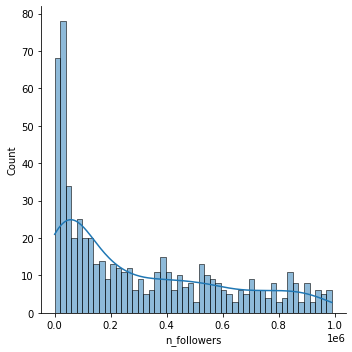

In [6]:
sns.displot(just_users[just_users['n_followers'] < 1000000], x='n_followers', bins=50, kde=True)

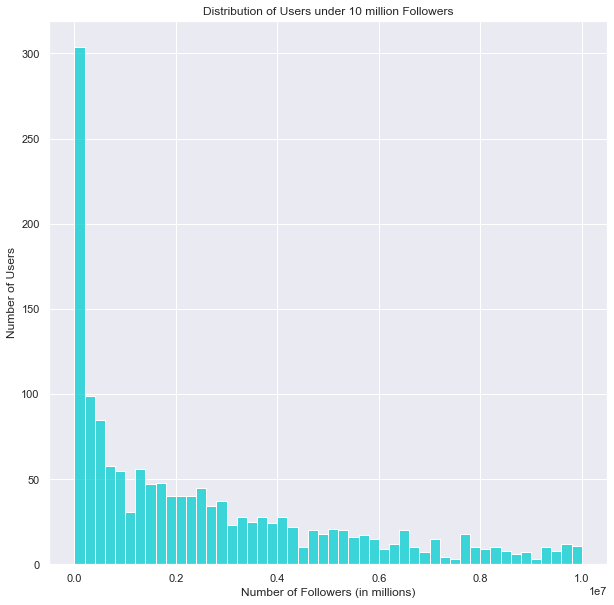

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

sns.set_theme()
sns.histplot(just_users[just_users['n_followers'] <= 10000000], x='n_followers', bins=50, ax=ax, color='darkturquoise')
plt.ylabel('Number of Users')
plt.xlabel('Number of Followers (in millions)')
plt.title("Distribution of Users under 10 million Followers")
plt.savefig('user_followers_distr_1.png', dpi=1000, facecolor='w')

In [8]:
# fig, ax = plt.subplots(figsize=(10, 10))

# sns.set_theme()
# sns.histplot(just_users, x='n_followers', bins=100, ax=ax)
# plt.ylabel('Number of Users')
# plt.xlabel('Number of Followers (in millions)')
# plt.title("Distribution of Users")
# plt.savefig('user_followers_distr_2.png', dpi=1000, facecolor='w')

## Determining which videos are trending/better performing

Using standard deviation, we are able to determine which videos of each users aer better performing compared to teh rest of the videos from the user.

In [9]:
by_user = {}
for i in just_users['user_name']:
    by_user[i] = sug[sug['user_name'] == i][1:].reset_index(drop = True)
    # ignored first entry because video might have just been posted
#by_user

### Outliers Function

This function inputs a list of values and the desired standard deviation for determining outliers.

The function outputs a list of indices of upper outliers based on the standard deviation chosen.

In [10]:
def upper_outliers(x, std = 1):
    outliers_index = []
    Xmean = mean(x)
    Xstd = stdev(x)
    limit = Xmean + std*Xstd
    for i, val in enumerate(x):
        if val > limit:
            outliers_index.append(i)
    return outliers_index

In [11]:
for i in by_user:
    try:
        by_user[i].loc[upper_outliers(by_user[i]['n_plays'], 1), 'outlier_1'] = True
        by_user[i].loc[upper_outliers(by_user[i]['n_plays'], 2), 'outlier_2'] = True
        by_user[i].loc[pd.isnull(by_user[i]['outlier_1']), 'outlier_1'] = False
        by_user[i].loc[pd.isnull(by_user[i]['outlier_2']), 'outlier_2'] = False
    except:
        # users with less than 2 posts
        by_user[i].loc[0, 'outlier_1'] = False
        by_user[i].loc[0, 'outlier_2'] = False

### Reforming the by_user dictionary back to full data frame

In [12]:
sug_df = pd.concat([by_user[i] for i in by_user]).reset_index(drop = True)

In [13]:
sug_df

,id,create_time,user_name,hashtags,song,video_length,n_likes,n_shares,n_comments,n_plays,n_followers,n_total_likes,n_total_vids,outlier_1,outlier_2
0,6.891790e+18,1.604620e+09,john.cena10,"['johncena', 'love', 'tiktok', 'halloween', 'q...",الصوت الأصلي,6.0,7372.0,9.0,51.0,52800.0,1000000.0,4700000.0,211.0,False,False
1,6.891265e+18,1.604498e+09,john.cena10,"['johncena', 'love', 'fyp', 'foryoupage']",The Time Is Now (John Cena),5.0,4623.0,11.0,27.0,37700.0,1000000.0,4700000.0,211.0,False,False
2,6.891050e+18,1.604448e+09,john.cena10,"['johncena', 'fyp', 'foryoupage', 'viral', 'co...",الصوت الأصلي,6.0,7931.0,6.0,24.0,51200.0,1000000.0,4700000.0,211.0,False,False
3,6.890886e+18,1.604409e+09,john.cena10,"['johncena', 'foryoupage', 'fyp', 'viral']",الصوت الأصلي,15.0,3229.0,9.0,14.0,24700.0,1000000.0,4700000.0,211.0,False,False
4,6.890500e+18,1.604320e+09,john.cena10,"['johncena', 'foryoupage', 'fyp', 'viral', 'co...",الصوت الأصلي,23.0,8021.0,24.0,54.0,49600.0,1000000.0,4700000.0,211.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,6.886179e+18,1.603314e+09,victoriabachlet,[],original sound,19.0,23900.0,48.0,181.0,110300.0,3600000.0,141500000.0,987.0,False,False
39996,6.885925e+18,1.603254e+09,victoriabachlet,[],original sound,13.0,40300.0,211.0,229.0,181100.0,3600000.0,141500000.0,987.0,False,False
39997,6.885815e+18,1.603229e+09,victoriabachlet,[],original sound,18.0,21400.0,49.0,142.0,106800.0,3600000.0,141500000.0,987.0,False,False
39998,6.885807e+18,1.603227e+09,victoriabachlet,[],wheres my love by syml,18.0,50100.0,331.0,1148.0,188800.0,3600000.0,141500000.0,987.0,False,False


In [14]:
print("outliers of 1 std:", sum(sug_df['outlier_1']))
print("non-outliers:", len(sug_df) - sum(sug_df['outlier_1']))

outliers of 1 std: 4420
non-outliers: 35580


In [15]:
print("outliers of 2 std:", sum(sug_df['outlier_2']))
print("non-outliers:", len(sug_df) - sum(sug_df['outlier_2']))

outliers of 2 std: 2229
non-outliers: 37771


In [16]:
sug_df = sug_df.loc[sug_df['video_length'] <= 60].reset_index(drop = True)

In [84]:
print(mean(sug_df.loc[sug_df['outlier_1']]['video_length']))
print('\n')
print(median(sug_df.loc[sug_df['outlier_1']]['video_length']))

18.714964908308808


14.0


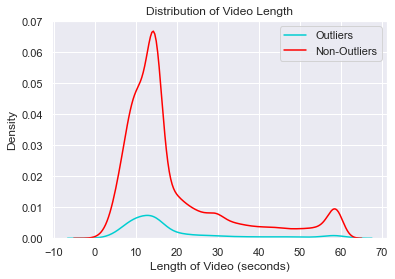

In [68]:
sns.kdeplot(data=sug_df, x='video_length', hue="outlier_1", palette=['red', 'darkturquoise'])
plt.ylabel('Density')
plt.xlabel('Length of Video (seconds)')
plt.title("Distribution of Video Length")
plt.legend(['Outliers', 'Non-Outliers'])
plt.savefig('dist_vid_len.png', dpi=1000, facecolor='w')

### Amount of Hashtags

Adding a column to sug_df that contains the amount of hashtags of each video

In [18]:
def amnt_of_hashtags(x):
    amnt = []
    for i in x:
        if i.replace("'", "").strip('][').split(', ') == ['']:
            amnt.append(0)
        else:
            amnt.append(len(i.replace("'", "").strip('][').split(', ')))
    return amnt

In [19]:
sug_df.columns

Index(['id', 'create_time', 'user_name', 'hashtags', 'song', 'video_length',
       'n_likes', 'n_shares', 'n_comments', 'n_plays', 'n_followers',
       'n_total_likes', 'n_total_vids', 'outlier_1', 'outlier_2'],
      dtype='object')

### Reording the columns of data frame

Also added a new column that contains the number of hashtags in each video

In [20]:
sug_df['n_hashtags'] = amnt_of_hashtags(sug_df['hashtags'])
sug_df = sug_df[['id', 'create_time', 'user_name', 'hashtags', 'n_hashtags',
                 'song', 'video_length', 'n_likes', 'n_shares', 'n_comments',
                 'n_plays', 'n_followers', 'n_total_likes', 'n_total_vids',
                 'outlier_1', 'outlier_2']]

<AxesSubplot:xlabel='n_hashtags', ylabel='Count'>

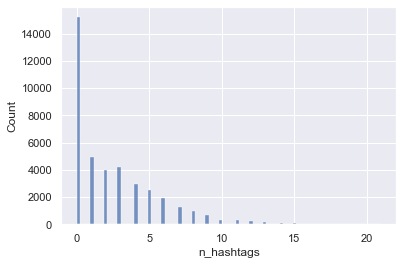

In [21]:
sns.histplot(data=sug_df, x='n_hashtags')

In [22]:
len(sug_df.loc[(sug_df['outlier_2']) & (sug_df['n_hashtags'] > 0)]) / len(sug_df.loc[sug_df['outlier_2']])

0.6234290843806104

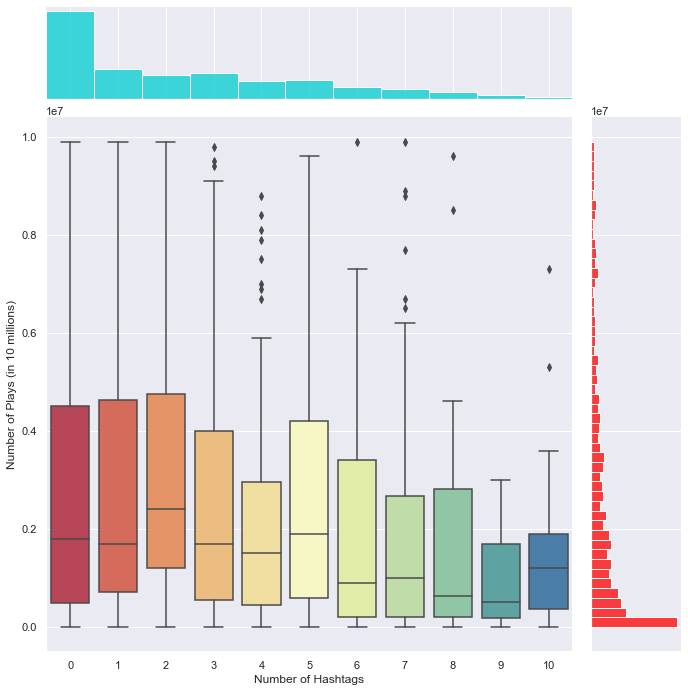

In [67]:
sns.set_theme()
df = sug_df.loc[(sug_df['outlier_2']) & (sug_df['n_plays'] < 10000000) & (sug_df['n_hashtags'] <= 10)]

g = sns.JointGrid()
g.fig.set_figwidth(10)
g.fig.set_figheight(10)

x, y = df['n_hashtags'], df['n_plays']
sns.histplot(x=x, bins=10, discrete=True, ax=g.ax_marg_x, color='darkturquoise')
sns.histplot(y=y, bins=50, ax=g.ax_marg_y, color='red')
sns.boxplot(x=x, y=y, ax=g.ax_joint, palette='Spectral')
g.set_axis_labels('Number of Hashtags', 'Number of Plays (in 10 millions)')
plt.savefig('nhashtags_vs_nplays.png', dpi=1000, facecolor='w')

## Hashtag Word Cloud

In [24]:
def extract_hashtags(x, unique = False):
    hashtags = []
    for i in x:
        # the lists of hashtags are stored as string representation of a list
        hashtags = hashtags + i.replace("'", "").strip('][').split(', ')
    if unique:
        return np.unique(hashtags)
    else:
        return hashtags

In [25]:
def freq_list(x):  
    freq = {} 
    for i in x: 
        if (i in freq): 
            freq[i] += 1
        else: 
            freq[i] = 1
    return freq

In [26]:
all_h = sorted(freq_list(extract_hashtags(sug_df['hashtags'])).items(),
             key=lambda x: x[1], reverse=True)
outlier_h = sorted(freq_list(extract_hashtags(sug_df.loc[sug_df['outlier_1']]['hashtags'])).items(),
                  key=lambda x: x[1], reverse=True)

In [27]:
def convert(tup):
    d = {'hashtag': [], 'count': []}
    for a, b in tup:
        d['hashtag'].append(a)
        d['count'].append(b)
    return d

In [28]:
all_df = pd.DataFrame.from_dict(data=convert(all_h)).set_index('hashtag')
outlier_df = pd.DataFrame.from_dict(data=convert(outlier_h)).set_index('hashtag').rename(columns={'count': 'outlier_count'})

In [29]:
hashtag_df = pd.concat([all_df, outlier_df], axis=1, sort=False)
hashtag_df.reset_index(inplace=True)
hashtag_df = hashtag_df.rename(columns={'index': 'hashtag'})

<AxesSubplot:xlabel='hashtag', ylabel='outlier_count'>

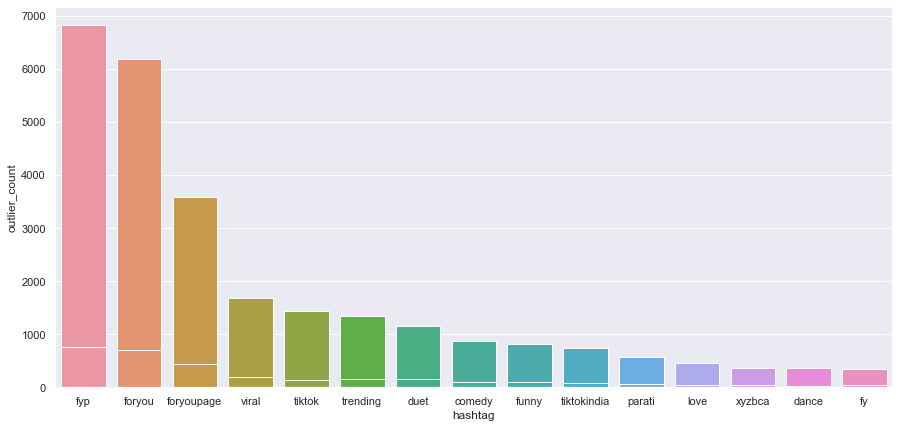

In [30]:
fig, ax = plt.subplots(figsize=(15, 7))


sns.barplot(data=hashtag_df.loc[1:15], x='hashtag', y='count', ax=ax)
sns.barplot(data=hashtag_df.loc[1:15], x='hashtag', y='outlier_count', ax=ax)

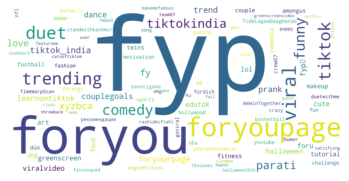

In [77]:
freq = freq_list(extract_hashtags(sug_df.loc[sug_df['outlier_1']]['hashtags']))
wc = WordCloud(background_color="white", max_words=100, width=4000, height=2000).generate_from_frequencies(freq)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
#wc.to_file('hash_wordcloud.png')

<AxesSubplot:xlabel='n_followers', ylabel='n_total_vids'>

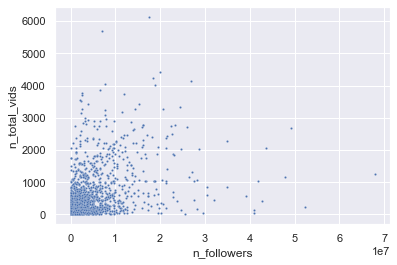

In [32]:
sns.scatterplot(data=just_users, x='n_followers', y='n_total_vids', s=5)

### see how shares correlate to views

In [33]:
x = sug_df['n_shares'].tolist()
y = sug_df['n_plays'].tolist()

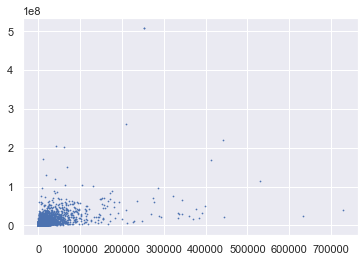

In [34]:
plt.scatter(x, y, s=.5)

# Below this is old code

In [35]:
def pct_atlst1(x):
    atlst1 = 0
    for i in x:
        if i > 0:
            atlst1 += 1
    return atlst1 / len(x)

In [36]:
print(pct_atlst1(amnt_of_hashtags(outliers_2_df['hashtags'])))
print('\n')
print(pct_atlst1(amnt_of_hashtags(non_outliers_2_df['hashtags'])))

NameError: name 'outliers_2_df' is not defined

In [ ]:
def extract_hashtags(x, unique = False):
    hashtags = []
    for i in x:
        # the lists of hashtags are stored as string representation of a list
        hashtags = hashtags + i.replace("'", "").strip('][').split(', ')
    if unique:
        return np.unique(hashtags)
    else:
        return hashtags

In [ ]:
outliers_hashtags_1 = extract_hashtags(outliers_1_df['hashtags'])
outliers_hashtags_2 = extract_hashtags(outliers_2_df['hashtags'])
non_outliers_hashtags_1 = extract_hashtags(non_outliers_1_df['hashtags'])
non_outliers_hashtags_2 = extract_hashtags(non_outliers_2_df['hashtags'])

In [ ]:
def freq_list(x):  
    freq = {} 
    for i in x: 
        if (i in freq): 
            freq[i] += 1
        else: 
            freq[i] = 1
    return freq

In [ ]:
sorted(freq_list(outliers_hashtags_1).items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted(freq_list(non_outliers_hashtags_1).items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted(test.items(), key=lambda x: x[1], reverse=True)

In [ ]:
test = freq_list(outliers_hashtags_2)
del test['']
#test

In [ ]:
len(test)

In [ ]:
wc = WordCloud(background_color="white", max_words=100, width=2000, height=1000).generate_from_frequencies(test)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
#wc.to_file('hash_wordcloud.png')